<a href="https://colab.research.google.com/github/GillianJ/Hello-World/blob/main/Food_vision_big_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THE FOOD VISION PROJECT**

In this project, I will be training 75 750 training images and 25 250 testing images with the aim of beating DeepFood https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

**Note:** Top-1 accuracy means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but **top-1** means only the highest one is evaluated). **Top-5** accuracy means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

**What I am going to cover**

  * Using TensorFlow Datasets to download and explore data
  * Creating preprocessing function for the data
  * Batching & preparing datasets for modelling (making our datasets run fast)
  * Creating modelling callbacks
  * Setting up mixed precision training
  * Building a feature extraction model (see transfer learning part 1: feature extraction)
  * Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
  * Viewing training results on TensorBoard


**Check GPU**

I am going to be using mixed precision training.

Mixed precision training was introduced in TensorFlow 2.4.0 

What does **mixed precision training **do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

In [13]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-171b38da-1284-3f27-344b-456b9f354c53)


In [14]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.4.1


**Get helper functions**

These are functions that I used prior to this therefore I will simply import instead of re writing them.

In [15]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-08-17 12:53:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-17 12:53:20 (77.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [16]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

**Use TensorFlow Datasets to Download Data** 

Why use TensorFlow Datasets?

  * Load data already in Tensors
  * Practice on well established datasets
  * Experiment with differet data loading techniques (like we're going to use in this notebook)
  * Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

  * The datasets are static (they don't change, like the real-world datasets would)
  * Might not be suited for the particular problem (but great for experimenting)
  
To begin using TensorFlow Datasets I can import it under the alias tfds.

In [17]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds


To find all of the available datasets in TensorFlow Datasets, I will use the list_builders() method.

After doing so, I will check to see if the one I am after ("food101") is present.

In [18]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?


True


To get access to the Food101 dataset from the TFDS, I can use the tfds.load() method.

In particular, I'll have to pass it a few parameters to let it know what I am after:

  * name (str) : the target dataset (e.g. "food101")
  * split (list, optional) : what splits of the dataset I am after (e.g. ["train", "validation"])
    * the split parameter is quite tricky. See the documentation for more.
  * shuffle_files (bool) : whether or not to shuffle the files on download, defaults to False
  * as_supervised (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
  * with_info (bool) : True to download dataset metadata (labels, number of samples, etc)

In [19]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

I can access the class names of a particular dataset using the dataset_info.features attribute and accessing names attribute of the the "label" key.

In [20]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [21]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

**Exploring the Food101 data from TensorFlow Datasets** 

Now I've downloaded the Food101 dataset from TensorFlow Datasets, I will do what any good data explorer should...

In other words, "visualize, visualize, visualize".

Here are a few details about the dataset:

* The shape of the input data (image tensors)
* The datatype of the input data
* What the labels of the input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, I‘ll take one sample off the training data (using the .take() method) and explore it.

In [22]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)


Because I used the as_supervised=True parameter in the tfds.load() method above, data samples come in the tuple format structure (data, label) or in my case (image_tensor, label).

In [23]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Let's loop through our single training sample and get some info from the image_tensor and label.


In [24]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (306, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 29
  Class name (str form): cup_cakes
        



Because I set the shuffle_files=True parameter in our tfds.load() method above, running the cell above a few times will give a different result each time.

Checking these I noticed that some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [25]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(306, 512, 3), dtype=uint8, numpy=
array([[[199, 100,  15],
        [192,  91,   9],
        [202,  95,  23],
        ...,
        [238, 196, 124],
        [237, 195, 123],
        [236, 194, 122]],

       [[210, 110,  25],
        [207, 105,  23],
        [194,  86,  13],
        ...,
        [238, 196, 124],
        [236, 194, 122],
        [235, 193, 121]],

       [[205, 103,  18],
        [213, 108,  25],
        [196,  86,  11],
        ...,
        [238, 195, 126],
        [237, 194, 125],
        [235, 192, 123]],

       ...,

       [[ 95,  28,  11],
        [ 94,  27,  10],
        [ 84,  17,   0],
        ...,
        [166,  32,   5],
        [166,  32,   3],
        [167,  34,   1]],

       [[ 87,  24,   7],
        [ 83,  18,   0],
        [ 87,  20,   1],
        ...,
        [155,  27,   0],
        [164,  39,   9],
        [156,  33,   0]],

       [[ 83,  21,   6],
        [ 79,  16,   0],
        [ 85,  19,   0],
        ...,
        [149,  25,   

In [26]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

**Plot an image from TensorFlow Datasets** 

I will plot one of the image samples using matplotlib.pyplot.imshow() and set the title to target class name.


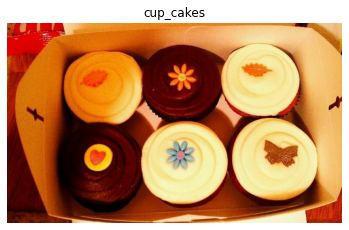

In [27]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

**Create preprocessing functions for our data**

However, since I've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps I have to take before it's ready to model.

More specifically, the data is currently:

  * In uint8 data type
  * Comprised of all differnet sized tensors (different sized images)
  * Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

  * In float32 data type
  * Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
  * Scaled (values between 0 & 1), also called normalized

To take care of these, I'll create a preprocess_img() function which:
  * Resizes an input image tensor to a specified size using tf.image.resize()
  * Converts an input image tensor's current datatype to tf.float32 using tf.cast()




In [28]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [29]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]]...,
Shape: (306, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[196.98405    96.515305   13.443877 ]
  [185.15625    75.776146   10.615431 ]
  [176.09981    62.711414    9.320153 ]
  ...
  [237.2455    192.6027    122.24549  ]
  [238.        196.        124.       ]
  [236.4598    194.4598    122.459785 ]]

 [[209.20886   106.47194    23.047512 ]
  [168.58833    56.285706    0.8501243]
  [166.6894     53.45121     2.8341837]
  ...
  [236.62468   192.2172    121.85998  ]
  [238.50987   195.96077   125.60809  ]
  [235.9958    193.4467    123.09402  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


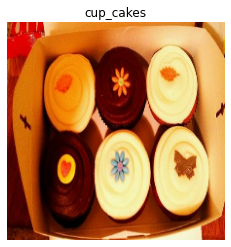

In [30]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

**Batch & prepare datasets**

Before I can model the data, I have to turn it into batches because computing on batches is memory efficient.

I will turn the data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of my GPU.

To do this in effective way, I am going to be leveraging a number of methods from the tf.data API.

Specifically, I am going to be using:

  
  * map() - maps a predefined function to a target dataset (e.g. preprocess_img() to the image tensors)
  * shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
  * batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
  * Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

  * Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
  * shuffle() keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if the training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
  * For methods with the num_parallel_calls parameter available (such as map()), setting it tonum_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed
  * Can't use cache() unless the dataset can fit in memory

In [31]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

**Create modelling callbacks**

Since I am going to be training on a large amount of data and the training could take a long time, it's a good idea to set up some modelling callbacks so that I can be sure of things like my model's training logs being tracked and the model being checkpointed (saved) after various training milestones.

To do each of these I'll use the following callbacks:

  * tf.keras.callbacks.TensorBoard() - allows to keep track of our model's training history so that it can inspected later (note: I've created this callback before & have imported it from helper_functions.py as create_tensorboard_callback())
  * tf.keras.callbacks.ModelCheckpoint() - saves the model's progress at various intervals so that I can load it and resuse it later without having to retrain it
    * Checkpointing is also helpful so I can start fine-tuning the model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [33]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [34]:
# downgrade tensorflow version because of an error on code
!pip install tensorflow==2.4.1

**Setup mixed precision training**

I touched on mixed precision training above.

However, I didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

The GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of the GPU's memory.

For tensors in float16 format, each element occupies 16 bits in computer memory.

First, we'll import the API and then use the set_global_policy() method to set the dtype policy to "mixed_float16".

In [35]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision


Now I can check the global dtype policy (the policy which will be used by layers in our model) using the mixed_precision.global_policy() method.

In [39]:
!nvidia-smi

Tue Aug 17 13:00:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    60W / 149W |    141MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

Great, since the global dtype policy is now "mixed_float16" our model will automatically take advantage of float16 variables where possible and in turn speed up training

**Build feature extraction model**

Callbacks: ready to roll.

Mixed precision: turned on.

I will start to  build a model.

Because the dataset is quite large, I am going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before I get into fine-tuning, I will set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

  1. Build a feature extraction model (replace the top few layers of a pretrained model)
  2. Train for a few epochs with lower layers frozen
  3. Fine-tune if necessary with multiple layers unfrozen

In [37]:
# create data augmentation layer to incorporate it into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# setup data augmentation 
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
], name="data_augmentation")                              


In [40]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)


# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [42]:
len(class_names)

101

In [41]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


**Checking layer dtype policies (are we using mixed precision?)**

Model ready to go!

Before I stated that the mixed precision API will automatically change the layers' dtype policy's to whatever the global dtype policy is (in this case it's "mixed_float16").

I can check this by iterating through the model's layers and printing layer attributes such as dtype and dtype_policy.

In [43]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


**Checking layer dtype policies (are we using mixed precision?)**

I can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.


In [44]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Summary of the above.

* `layer.name`: the human readable name of a particular layer.
* `layer.trainable`: is the layer trainable or not? (if `false`, the weights are frozen)
* `layer.dtype`: the data type of a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [45]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

**Fit the feature extraction model**

Now that's one good looking model. I will fit it to the.

Three epochs should be enough for the top layers to adjust their weights enough to our food image data.

To save time per epoch, I'll also only validate on 15% of the test data.

In [46]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210817-131739
Epoch 1/3
2368/2368 [==============================] - 1192s 476ms/step - loss: 4.6937 - accuracy: 0.0097 - val_loss: 4.6150 - val_accuracy: 0.0117
Epoch 2/3
2368/2368 [==============================] - 1105s 465ms/step - loss: 4.6157 - accuracy: 0.0091 - val_loss: 4.6150 - val_accuracy: 0.0119
Epoch 3/3
2368/2368 [==============================] - 1103s 465ms/step - loss: nan - accuracy: 0.0091 - val_loss: nan - val_accuracy: 0.0072


In [47]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 84s 106ms/step - loss: nan - accuracy: 0.0099


[nan, 0.00994059443473816]


**Load and evaluate checkpoint weights**

I can now load in and evaluate the model's checkpoints by:

  1. Cloning the model using tf.keras.models.clone_model() to make a copy of the feature extraction model with reset weights.
  2. Calling the load_weights() method on the cloned model passing it the path to where the checkpointed weights are stored.
  3. Calling evaluate() on the cloned model with loaded weights.

In [50]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [51]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [52]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

I recompiled the model because each time a change has been made to a model (including loading weights), it has to be recompiled.

In [53]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [54]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 79s 97ms/step - loss: 4.6151 - accuracy: 0.0104


The cloned model with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).

Cloning the model preserves dtype_policy's of layers (but doesn't preserve weights). If I wanted to continue fine-tuning with the cloned model, I could and would still use the mixed precision dtype policy.

In [56]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float


**Save the whole model to file**

I can also save the whole model using the save() method.

Since the model is quite large, I will save it to Google Drive (since I am using Google Colab) so that I can load it in for use later.

**🔑 Note:** Saving to Google Drive requires

In [59]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

In [58]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [60]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [61]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [62]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 79s 97ms/step - loss: nan - accuracy: 0.0099


[nan, 0.00994059443473816]